In [1]:
import numpy as np
import pandas as pd
from scipy import integrate, optimize, stats, signal
import matplotlib.pyplot as plt

In [2]:
def GRM_ODE(t, C, r, p, K, a):
    return r*np.power(C, p)*(1-np.power((C/K), a))

def GRM(t, C0, r, p, K, a, rtol=1e-6):
    return integrate.solve_ivp(GRM_ODE, (t[0], t[-1]), [C0], t_eval=t, args=(r, p, K, a), rtol=rtol).y[0]

In [3]:
data = pd.read_json("https://epistat.sciensano.be/Data/COVID19BE_CASES_AGESEX.json")
data["DATE"] = pd.to_datetime(data["DATE"])

In [4]:
cases = data.groupby("DATE")["CASES"].sum().to_frame()
cases["index"] = (cases.index - cases.index[0])//pd.Timedelta("1d")
cases["cumsum"] = cases["CASES"].cumsum()
cases = cases.reset_index().rename(columns={"CASES": "daily", "DATE": "date"}).set_index("date")
cases["cs_mv14d"] = cases["cumsum"].rolling(14).mean().shift(-7)
cases["d_mv14d"] = cases["cs_mv14d"].diff()
cases["cs_savgol"] = signal.savgol_filter(cases["cumsum"], 31, 7)
cases["d_savgol"] = cases["cs_savgol"].diff()
cases.to_csv("covid.csv", index=False)
cases.sample(10)

,daily,index,cumsum,cs_mv14d,d_mv14d,cs_savgol,d_savgol
date,,,,,,,
2021-10-03,678,581,1244057,1.246611e+06,2018.142857,1.245260e+06,1797.682549
2020-05-29,165,89,58854,5.877064e+04,147.642857,5.876082e+04,131.729755
2020-05-23,123,83,57745,5.779764e+04,191.857143,5.776824e+04,196.200033
2020-07-08,137,129,62742,6.284193e+04,119.285714,6.270552e+04,94.854365
2020-09-23,2096,206,111690,1.124727e+05,1808.142857,1.110054e+05,1644.904011
2021-08-01,1056,518,1121526,1.123250e+06,1680.500000,1.122214e+06,1648.633622
2021-08-31,2358,548,1180378,1.181177e+06,1995.000000,1.180289e+06,1978.248076
2020-07-04,64,125,62370,6.241379e+04,94.428571,6.236632e+04,91.086854
2021-10-01,2149,579,1242232,1.242581e+06,1996.357143,1.241507e+06,1970.732996


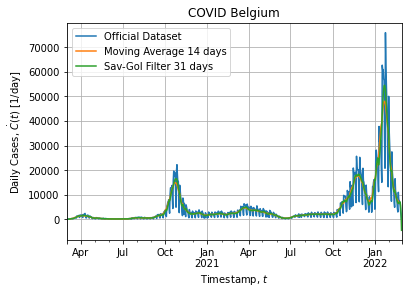

In [5]:
axe = cases["daily"].plot(label="Official Dataset")
cases["d_mv14d"].plot(ax=axe, label="Moving Average 14 days")
cases["d_savgol"].plot(ax=axe, label="Sav-Gol Filter 31 days")
axe.legend()
axe.set_title("COVID Belgium")
axe.set_xlabel(r"Timestamp, $t$")
axe.set_ylabel(r"Daily Cases, $\dot{C}(t)$ [1/day]")
axe.grid()

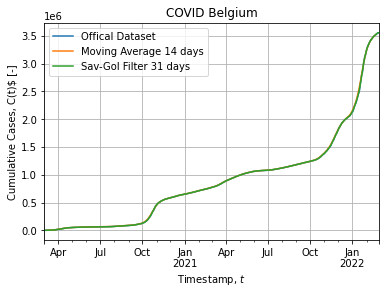

In [6]:
axe = cases["cumsum"].plot(label="Offical Dataset")
cases["cs_mv14d"].plot(ax=axe, label="Moving Average 14 days")
cases["cs_savgol"].plot(ax=axe, label="Sav-Gol Filter 31 days")
axe.set_yscale("linear")
axe.legend()
axe.set_title("COVID Belgium")
axe.set_xlabel(r"Timestamp, $t$")
axe.set_ylabel(r"Cumulative Cases, C(t)$ [-]")
axe.grid()

In [7]:
t0 = "2021-12-21"
t1 = "2022-02-21"

In [8]:
peak = cases.loc[(cases.index >= t0) & (cases.index < t1), :]
for k in ["index", "cumsum", "cs_mv14d"]:
    peak[k + "_origin"] = peak[k] - peak[k][0]
peak.sample(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,daily,index,cumsum,cs_mv14d,d_mv14d,cs_savgol,d_savgol,index_origin,cumsum_origin,cs_mv14d_origin
date,,,,,,,,,,
2022-02-18,7712,719,3506288,3.504155e+06,8111.142857,3.504704e+06,7697.223355,59,1478817,1.472770e+06
2022-01-29,23221,699,3150353,3.145549e+06,36972.857143,3.150413e+06,37889.794382,39,1122882,1.114165e+06
2022-01-23,20747,693,2844998,2.893989e+06,47866.142857,2.879585e+06,53550.825858,33,817527,8.626049e+05
2022-02-08,19394,709,3395965,3.393023e+06,16313.571429,3.396129e+06,15881.313797,49,1368494,1.361638e+06
2022-01-02,9086,672,2138955,2.173582e+06,17030.428571,2.152666e+06,15885.877771,12,111484,1.421979e+05


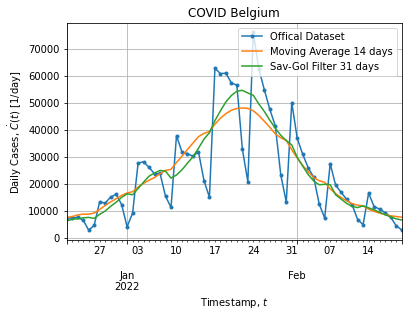

In [9]:
axe = peak["daily"].plot(linestyle="-", marker=".", label="Offical Dataset")
peak["d_mv14d"].plot(ax=axe, label="Moving Average 14 days")
peak["d_savgol"].plot(ax=axe, label="Sav-Gol Filter 31 days")
axe.legend()
axe.set_title("COVID Belgium")
axe.set_xlabel(r"Timestamp, $t$")
axe.set_ylabel(r"Daily Cases, $\dot{C}(t)$ [1/day]")
axe.grid()

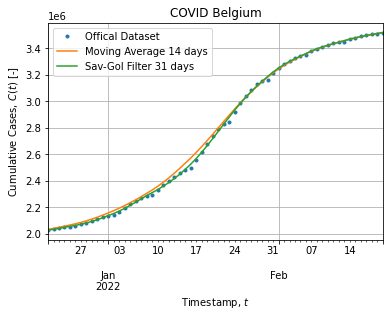

In [10]:
axe = peak["cumsum"].plot(marker=".", linestyle="none", label="Offical Dataset")
peak["cs_mv14d"].plot(ax=axe, label="Moving Average 14 days")
peak["cs_savgol"].plot(ax=axe, label="Sav-Gol Filter 31 days")
axe.legend()
axe.set_title("COVID Belgium")
axe.set_xlabel(r"Timestamp, $t$")
axe.set_ylabel(r"Cumulative Cases, $C(t)$ [-]")
axe.grid()

In [11]:
popt, pcov = optimize.curve_fit(
    GRM, peak["index_origin"].values, peak["cumsum_origin"].values, p0=(2e4, 1.1, 0.8, 1.5e6, 1),
    bounds=([1, 0.1, 0.1, 50, 0.1], [1e7, 10, 1, 1e7, 10]),
    gtol=1e-9, max_nfev=10000
)
print(popt)

[1.64271209e+04 2.23809000e+00 7.57094438e-01 1.49092450e+06
 2.13587834e+00]


In [12]:
def resample(frame):
    sample = frame.set_index("index_origin")
    index = np.arange(sample.index.min(), sample.index.max() + 0.0001, 0.1)
    sample = sample.reindex(index).interpolate().reset_index(drop=False)
    sample = sample.sample(frac=1.0, replace=True).sort_index()
    count = sample.groupby(sample.index)["index"].count()
    count.name = "count"
    sample = sample.drop_duplicates().merge(count, left_index=True, right_index=True)
    sample = sample.sort_index()
    sample["sigma"] = 1/sample["count"]
    return sample
resample(peak)

,index_origin,daily,index,cumsum,cs_mv14d,d_mv14d,cs_savgol,d_savgol,cumsum_origin,cs_mv14d_origin,count,sigma
1,0.1,7373.7,660.1,2028209.9,2.032170e+06,7481.092857,2.027071e+06,6259.330550,738.9,7.851571e+02,2,0.500000
2,0.2,7375.4,660.2,2028948.8,2.032955e+06,7522.257143,2.027755e+06,6323.605532,1477.8,1.570314e+03,1,1.000000
4,0.4,7378.8,660.4,2030426.6,2.034525e+06,7604.585714,2.029122e+06,6452.155497,2955.6,3.140629e+03,1,1.000000
5,0.5,7380.5,660.5,2031165.5,2.035310e+06,7645.750000,2.029806e+06,6516.430480,3694.5,3.925786e+03,3,0.333333
7,0.7,7383.9,660.7,2032643.3,2.036880e+06,7728.078571,2.031174e+06,6644.980444,5172.3,5.496100e+03,2,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
605,60.5,3713.5,720.5,3512249.0,3.515822e+06,7737.785714,3.514990e+06,6782.568540,1484778.0,1.484438e+06,3,0.333333
607,60.7,3400.9,720.7,3512835.4,3.517346e+06,7688.928571,3.516302e+06,6693.020144,1485364.4,1.485961e+06,2,0.500000
608,60.8,3244.6,720.8,3513128.6,3.518107e+06,7664.500000,3.516958e+06,6648.245946,1485657.6,1.486723e+06,1,1.000000
609,60.9,3088.3,720.9,3513421.8,3.518869e+06,7640.071429,3.517614e+06,6603.471747,1485950.8,1.487484e+06,1,1.000000


In [14]:
params = []
for i in range(200):
    # Resampling:
    sample = resample(peak)
    # Adjusting
    popt, pcov = optimize.curve_fit(
        GRM,
        sample["index_origin"].values, sample["cs_mv14d_origin"].values, sigma=sample["sigma"].values,
        p0=(2e4, 1.1, 0.8, 1.5e6, 1), bounds=([1, 0.1, 0.1, 50, 0.1], [1e7, 10, 1, 1e7, 10]),
        gtol=1e-9, max_nfev=10000
    )
    params.append(popt)
params = pd.DataFrame(params, columns=["C", "r", "p", "K", "a"])
params.to_csv("bootstrap.csv", index=False)

In [ ]:
#params = pd.read_csv("bootstrap_01.csv")

In [15]:
params.sample(5)

,C,r,p,K,a
9,15812.316307,4.882451,0.693344,1.496949e+06,2.227446
14,15642.223045,5.442004,0.684438,1.501430e+06,2.225887
19,17195.811238,3.720538,0.715939,1.503312e+06,2.030779
5,15549.123938,5.076145,0.690602,1.500071e+06,2.175967
18,15809.122791,4.825186,0.694448,1.503828e+06,2.173949


In [16]:
params.describe()

,C,r,p,K,a
count,20.000000,20.000000,20.000000,2.000000e+01,20.000000
mean,16497.998312,4.641331,0.698080,1.501091e+06,2.166272
std,836.010630,0.570668,0.010524,2.553202e+03,0.074173
min,15367.571039,3.327061,0.681502,1.496949e+06,2.006989
25%,15894.556590,4.353556,0.691871,1.498883e+06,2.123596
50%,16156.134322,4.714107,0.696301,1.501125e+06,2.167537
75%,17160.219478,4.984272,0.702243,1.502895e+06,2.212481
max,18284.284310,5.633960,0.724558,1.506533e+06,2.288444


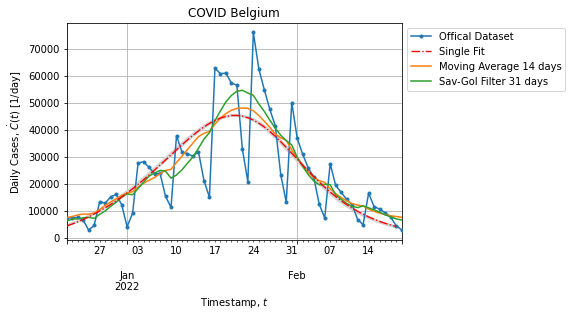

In [20]:
axe = peak["daily"].plot(linestyle="-", marker=".", label="Offical Dataset", zorder=1000)
for row in params.itertuples():
    c = GRM(peak["index"], *row[1:])
    axe.plot(peak.index[:-1], np.diff(c), color="lightgrey", linewidth=1.35)
c = GRM(peak["index"], *popt)
axe.plot(peak.index[:-1], np.diff(c), "-.", color="red", linewidth=1.35, label="Single Fit", zorder=2000)
peak["d_mv14d"].plot(ax=axe, label="Moving Average 14 days", zorder=1001)
peak["d_savgol"].plot(ax=axe, label="Sav-Gol Filter 31 days", zorder=1002)
axe.legend(bbox_to_anchor=(1,1), loc="upper left")
axe.set_title("COVID Belgium")
axe.set_xlabel(r"Timestamp, $t$")
axe.set_ylabel(r"Daily Cases, $\dot{C}(t)$ [1/day]")
axe.grid()

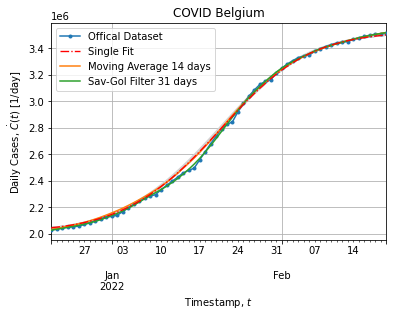

In [21]:
fig, axe = plt.subplots()
peak["cumsum"].plot(linestyle="-", marker=".", label="Offical Dataset", zorder=1000)
for row in params.itertuples():
    c = GRM(peak["index"], *row[1:]) + peak["cumsum"][0]
    axe.plot(peak.index, c, color="lightgrey", linewidth=1.35)
c = GRM(peak["index"], *popt) + peak["cumsum"][0]
axe.plot(peak.index, c, "-.", color="red", linewidth=1.35, label="Single Fit", zorder=2000)
peak["cs_mv14d"].plot(ax=axe, label="Moving Average 14 days", zorder=1001)
peak["cs_savgol"].plot(ax=axe, label="Sav-Gol Filter 31 days", zorder=1002)
axe.legend()
axe.set_title("COVID Belgium")
axe.set_xlabel(r"Timestamp, $t$")
axe.set_ylabel(r"Daily Cases, $\dot{C}(t)$ [1/day]")
axe.grid()

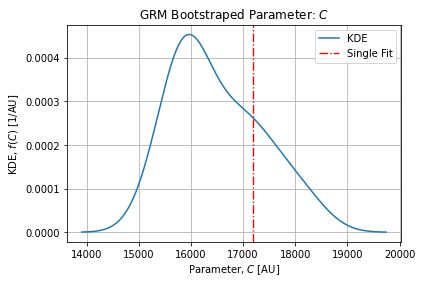

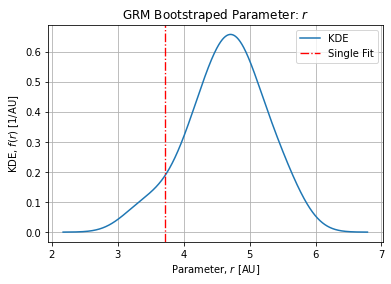

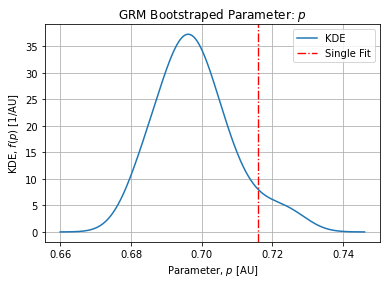

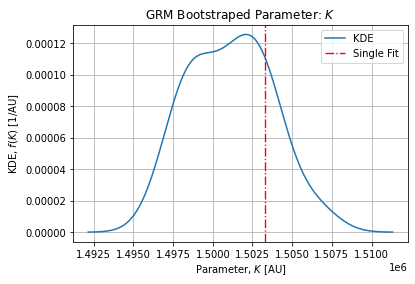

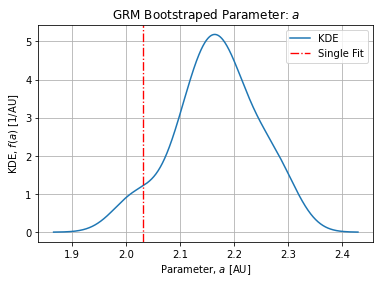

In [22]:
for i, k in enumerate(params):
    fig, axe = plt.subplots()
    params[k].plot(kind="kde", ax=axe, label="KDE")
    axe.axvline(popt[i], linestyle="-.", color="red", linewidth=1.35, label="Single Fit")
    axe.legend()
    axe.set_title(r"GRM Bootstraped Parameter: $%s$" % k)
    axe.set_xlabel(r"Parameter, $%s$ [AU]" % k)
    axe.set_ylabel(r"KDE, $f(%s)$ [1/AU]" % k)
    axe.grid()